# Prototype: Compute cell volumes using lookup table in HEC-RAS HDF5 file

This notebook contains code to compute cell volumes and face areas using the current water surface elevation for each cell. The volumes and face areas
of incompletely inundated cells is stored in tables in the HEC-RAS HDF file. A lookup table approach is used below to interpolate the cell volume
and face area of each cell using that cell's water surface elevation at the current time step.

Note: The code in this notebook uses xarray and pandas to store the data read from HDF5, display the metadata, etc. However, the only benefit of this
approach is it improves the data management. In order to rapidly compute the cell volumes and face areas using numba, all values needed to be extracted 
as numpy arrays.

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
import numba
import seaborn as sns

sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('whitegrid')

## Functions

In [2]:
def parse_attributes(dataset):
    '''Parse the HDF5 attributes array, convert binary strings to Python strings, and return a dictionary of attributes'''
    attrs = {}
    for key, value in dataset.attrs.items():
        # print('type(value) = ', type(value))
        if type(value) == np.bytes_:
            attrs[key] = value.decode('ascii')
        elif type(value) == np.ndarray:
            values = []
            for v in value:
                if type(v) == np.bytes_:
                    values.append(v.decode('ascii'))
                else:
                    values.append(v)
            attrs[key] = values
        else:
            attrs[key] = value
    return attrs

def read_dataset_xarray(filepath, datapath, dims) -> xr.DataArray:
    '''Read n-dimensional HDF5 dataset and return it as an xarray.DataArray'''
    with h5py.File(filepath) as infile:
        dataset = infile[datapath]
        attrs = parse_attributes(dataset)
        coords = {}
        for i in range(len(dataset.shape)):
            coords[dims[i]] = list(range(dataset.shape[i]))
        data_array = xr.DataArray(dataset[()], coords = coords, dims = dims, attrs = attrs)
        return data_array

def read_dataset_pandas(filepath, datapath) -> pd.DataFrame:
    '''Read n-dimensional HDF5 dataset and return it as an xarray.DataArray'''
    with h5py.File(filepath) as infile:
        dataset = infile[datapath]
        attrs = parse_attributes(dataset)
        df = pd.DataFrame(dataset[()], columns = attrs['Column'])
        return df

@numba.njit
def compute_cell_volumes(water_surface_elev_arr: np.ndarray, cells_surface_area_arr: np.ndarray, starting_index_arr: np.ndarray, count_arr: np.ndarray, elev_arr: np.ndarray, vol_arr: np.ndarray, ntimes: int, ncells: int, VERBOSE=False) -> float:
    '''Compute the volumes of the RAS cells using lookup tables'''
    cell_volumes = np.zeros((ntimes, ncells))

    for time in range(ntimes):
        for cell in range(ncells):
            water_surface_elev = water_surface_elev_arr[time, cell]
            surface_area = cells_surface_area_arr[cell]
            index = starting_index_arr[cell] # Start index in the volume-elevation table for this cell
            count = count_arr[cell] # Number of points in the table for this cell

            # A number of cells have an index that is just past the end of the array. According to Mark Jensen, 
            # these are ghost cells and have a volume of 0.0. The count for these cells should also always be zero. 
            # The code checks for either condition.
            if index >= len(elev_arr) or count == 0:
                cell_volumes[time, cell] = 0.0
            else:
                elev = elev_arr[index:index + count] # Get the water surface elevation array for this cell
                vol = vol_arr[index:index + count] # Get the volume array for this cell

                if water_surface_elev > elev[-1]:
                    '''
                    Compute the net volume: the max volume in the lookup table plus the volume of the water above the max 
                    elevation in the lookup table.
                    
                    Note: this assumes a horizontal water surface, i.e., that the slope of the water surface across a cell
                    is negligible. The error increases with cell size.
                    
                    The validity of this method was confirmed by Mark Jensen on Jul 29, 2022.
                    '''
                    cell_volumes[time, cell] = vol[-1] + (water_surface_elev - elev[-1]) * surface_area
                elif water_surface_elev == elev[-1]:
                    cell_volumes[time, cell] = vol[-1]
                elif water_surface_elev <= elev[0]:
                    cell_volumes[time, cell] = vol[0]
                else:
                    # Interpolate
                    cell_volumes[time, cell] = 0.0 # Default
                    npts = len(elev)
                    for i in range(npts-1, -1, -1):
                        if elev[i] < water_surface_elev:
                            x = water_surface_elev
                            m = (vol[i] - vol[i-1])/(elev[i] - elev[i-1])
                            x1 = elev[i]
                            y1 = vol[i]
                            # y = m * (x - x1) + y1
                            cell_volumes[time, cell] = m * (x - x1) + y1

    return cell_volumes

@numba.njit
def compute_face_areas(water_surface_elev_arr: np.ndarray, faces_lengths_arr: np.ndarray, faces_cell_indexes_arr: np.ndarray, starting_index_arr: np.ndarray, count_arr: np.ndarray, elev_arr: np.ndarray, area_arr: np.ndarray, ntimes: int, ncells: int, nfaces: int):
    '''Compute the areas of the RAS cell faces using lookup tables'''
    face_areas = np.zeros((ntimes, nfaces))
    for time in range(ntimes):
        for face in range(nfaces):
            cell = faces_cell_indexes_arr[face]
            water_surface_elev = water_surface_elev_arr[time, cell]
            index = starting_index_arr[face] # Start index in the area-elevation table for this cell (note: this is indexed by faces)
            count = count_arr[face] # Number of points in the table for this cell (note: this is indexed by faces)

            # A number of cells have an index that is just past the end of the array. According to Mark Jensen, 
            # these are ghost cells and have a volume of 0.0. The count for these cells should also always be zero. 
            # The code checks for either condition.
            if index >= len(elev_arr) or count == 0:
                face_areas[time, face] = 0.0
            else:
                elev = elev_arr[index:index + count] # Get the water surface elevation (Z) array for this face
                area = area_arr[index:index + count] # Get the face area array for this face

                if water_surface_elev > elev[-1]:
                    '''
                    Compute the net face surface area: the max face area in the lookup table plus the face area of 
                    the water above the max elevation in the lookup table.
                    
                    Note: this assumes a horizontal water surface, i.e., that the slope of the water surface across a cell face
                    is negligible. The error increases with cell size.
                    
                    The validity of this method was confirmed by Mark Jensen on Jul 29, 2022.
                    '''
                    face_areas[time, face] = area[-1] + (water_surface_elev - elev[-1]) * faces_lengths_arr[face]
                elif water_surface_elev == elev[-1]:
                    face_areas[time, face] = area[-1]
                elif water_surface_elev <= elev[0]:
                    face_areas[time, face] = area[0]
                else:
                    # Interpolate
                    face_areas[time, face] = 0.0 # Default
                    npts = len(elev)
                    for i in range(npts-1, -1, -1):
                        if elev[i] < water_surface_elev:
                            x = water_surface_elev
                            m = (area[i] - area[i-1])/(elev[i] - elev[i-1])
                            x1 = elev[i]
                            y1 = area[i]
                            # y = m * (x - x1) + y1
                            y = m * (x - x1) + y1
                            # print('i, x, m, x1, y1, y: ', i, x, m, x1, y1, y)
                            face_areas[time, face] = y
                            if face_areas[time, face] < 0:
                                print('Computed face area = ', face_areas[time, face])
                                print('Time Step: ', time)
                                print('Cell number: ', cell)
                                print('Face number: ', face)
                                print('water_surface_elev: ', water_surface_elev)
                                print('elev: ', elev)
                                print('area: ', area)
                                # msg = 'Negative face area: computed face area = ' + str(face_areas[time, face])
                                raise(ValueError('Negative face area'))


    return face_areas

## Example: Compute the cell volumes for the Muncie example watershed

### Read the data

In [3]:
# HEC-RAS input file
infile = '../tests/input_files/Muncie.p04.hdf'

# Results time series: Water Surface Elevation
water_surface_elev_xr = read_dataset_xarray(infile, 'Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/2D Interior Area/Water Surface', dims = ['Time', 'Cells'])

# Geometry: Cell Volumes
cells_volume_elevation_info_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Cells Volume Elevation Info')
cells_volume_elevation_values_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Cells Volume Elevation Values')

# Geometry: Cell Surface Area
cells_surface_area_xr = read_dataset_xarray(infile, 'Geometry/2D Flow Areas/2D Interior Area/Cells Surface Area', dims = ['Rows'])

# Display the data
# display(water_surface_elev_xr)
# display(cells_volume_elevation_info_df)
# display(cells_volume_elevation_values_df)
# display(cells_surface_area_xr)

#### Compute the cell volumes

In [4]:
# ntimes = 289
# ncells = 5765
ntimes, ncells = water_surface_elev_xr.shape

cell_volumes = compute_cell_volumes(
    water_surface_elev_xr.values,
    cells_surface_area_xr.values,
    cells_volume_elevation_info_df['Starting Index'].values,
    cells_volume_elevation_info_df['Count'].values,
    cells_volume_elevation_values_df['Elevation'].values,
    cells_volume_elevation_values_df['Volume'].values,
    ntimes,
    ncells)
cell_volumes_df = pd.DataFrame(cell_volumes, columns = range(ncells))
cell_volumes_df

,0,1,2,3,4,5,6,7,8,9,...,5755,5756,5757,5758,5759,5760,5761,5762,5763,5764
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,11781.545898,10580.918945,11696.687500,11255.155273,10983.076172,15212.147461,13285.705078,15499.646484,17601.767578,19045.613281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,11777.916016,10577.850586,11693.376953,11251.775391,10979.221680,15208.108398,13282.004883,15495.236328,17596.714844,19040.261719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,11774.286133,10574.782227,11690.066406,11248.395508,10975.367188,15204.069336,13278.303711,15490.826172,17591.662109,19035.130859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,11770.656250,10571.713867,11686.755859,11245.014648,10971.513672,15200.031250,13274.603516,15486.416016,17586.609375,19029.556641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Plot the cell volumes

Text(0, 0.5, 'Cell Volume')

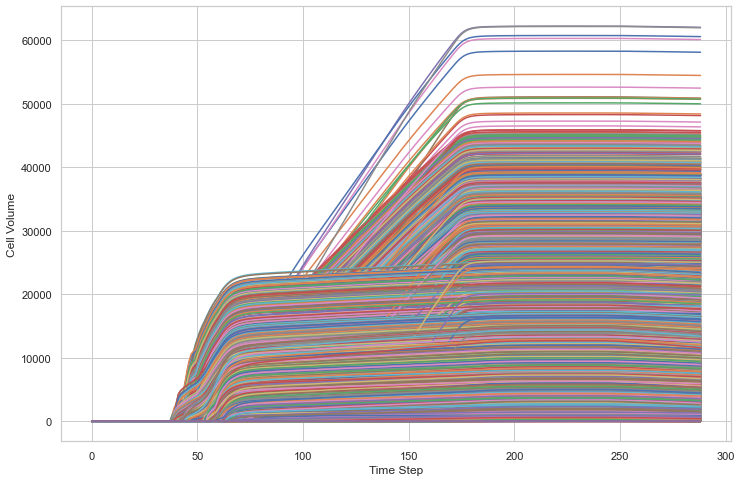

In [5]:
ax = cell_volumes_df.plot(legend=None)
ax.set_xlabel('Time Step')
ax.set_ylabel('Cell Volume')

## Example: Compute the cell face areas for the Muncie example watershed

### Read the data

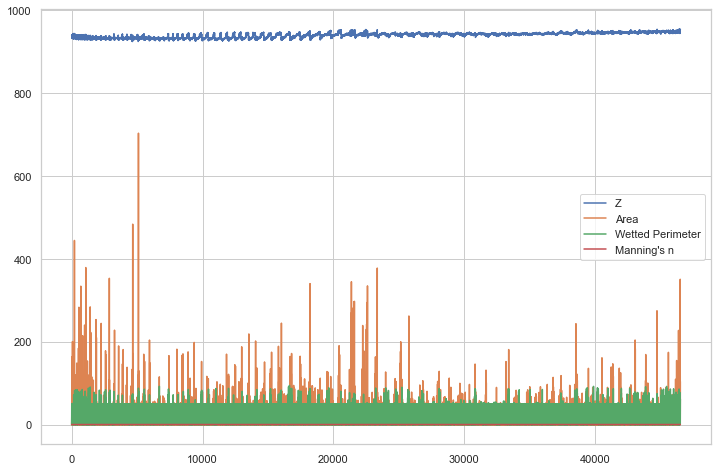

In [6]:
# HEC-RAS input file
infile = '../tests/input_files/Muncie.p04.hdf'

# Results time series: Water Surface Elevation
water_surface_elev_xr = read_dataset_xarray(infile, 'Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/2D Flow Areas/2D Interior Area/Water Surface', dims = ['Time', 'Cells'])

# Geometry: Cell Face Areas
faces_area_elevation_info_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Faces Area Elevation Info')
faces_area_elevation_values_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Faces Area Elevation Values')
faces_area_elevation_values_df.plot()
faces_normalunitvector_and_length_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Faces NormalUnitVector and Length')
faces_cell_indexes_df = read_dataset_pandas(infile, 'Geometry/2D Flow Areas/2D Interior Area/Faces Cell Indexes')

# Display the data
# display(water_surface_elev_xr)
# display(faces_area_elevation_info_df)
# display(faces_area_elevation_values_df)
# display(faces_normalunitvector_and_length_df)
# display(faces_cell_indexes_df)
# water_surface_elev_xr.plot()
# faces_area_elevation_info_df.plot()
# faces_area_elevation_values_df.plot()
# faces_normalunitvector_and_length_df.plot()
# faces_cell_indexes_df.plot()

### Compute the face areas

In [7]:
# ntimes = 289
# ncells = 5765
# nfaces = 11164
ntimes, ncells = water_surface_elev_xr.shape
nfaces = faces_cell_indexes_df.shape[0]

Compute face areas using Cell 0 in the "Faces Cell Indexes" dataset:

In [8]:
face_areas_0 = compute_face_areas(
    water_surface_elev_xr.values,
    faces_normalunitvector_and_length_df['Face Length'].values,
    faces_cell_indexes_df['Cell 0'].values,
    faces_area_elevation_info_df['Starting Index'].values,
    faces_area_elevation_info_df['Count'].values,
    faces_area_elevation_values_df['Z'].values,
    faces_area_elevation_values_df['Area'].values,
    ntimes,
    ncells,
    nfaces)
face_areas_0_df = pd.DataFrame(face_areas_0, columns = range(nfaces))

Compute face areas using Cell 1 in the "Faces Cell Indexes" dataset

In [9]:
face_areas_1 = compute_face_areas(
    water_surface_elev_xr.values,
    faces_normalunitvector_and_length_df['Face Length'].values,
    faces_cell_indexes_df['Cell 1'].values,
    faces_area_elevation_info_df['Starting Index'].values,
    faces_area_elevation_info_df['Count'].values,
    faces_area_elevation_values_df['Z'].values,
    faces_area_elevation_values_df['Area'].values,
    ntimes,
    ncells,
    nfaces)
face_areas_1_df = pd.DataFrame(face_areas_1, columns = range(nfaces))

### Plot the face areas computed using the water surface elevation of Cell 0 in the "Faces Cell Indexes" dataset

Text(0, 0.5, 'Face Area (Using Cell 0 WSE)')

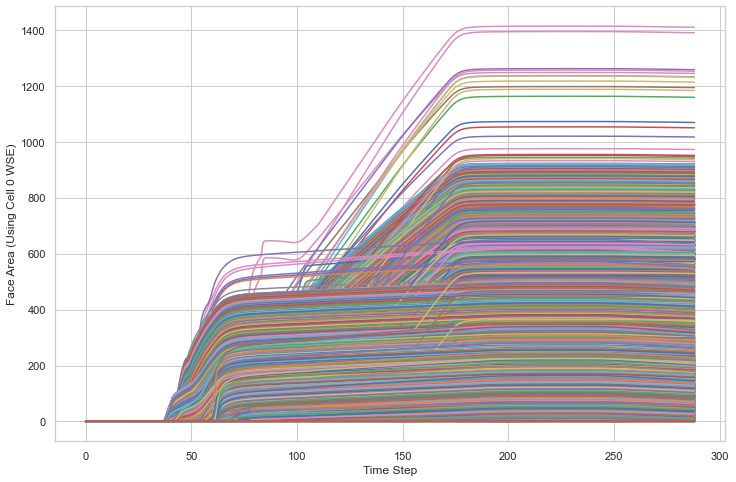

In [10]:
ax = face_areas_0_df.plot(legend=None)
ax.set_xlabel('Time Step')
ax.set_ylabel('Face Area (Using Cell 0 WSE)')

### Plot the face areas computed using the water surface elevation of Cell 1 in the "Faces Cell Indexes" dataset

Text(0, 0.5, 'Face Area (Using Cell 1 WSE)')

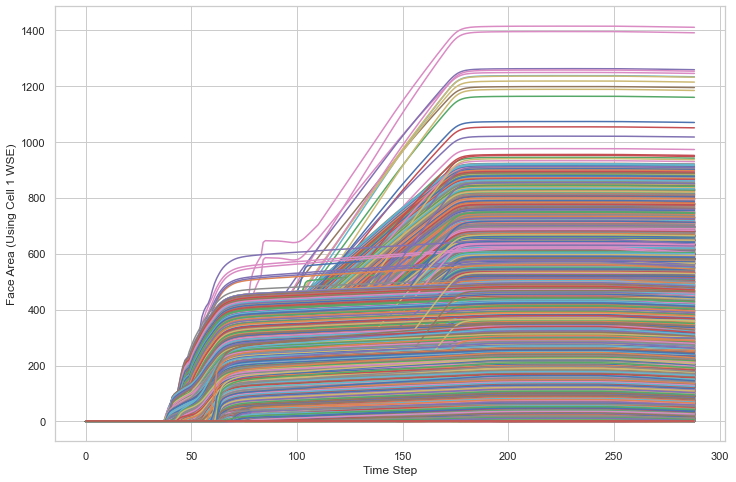

In [11]:
ax = face_areas_1_df.plot(legend=None)
ax.set_xlabel('Time Step')
ax.set_ylabel('Face Area (Using Cell 1 WSE)')

Text(0, 0.5, 'Face Area Difference (Cell_1_area - Cell_0_area)')

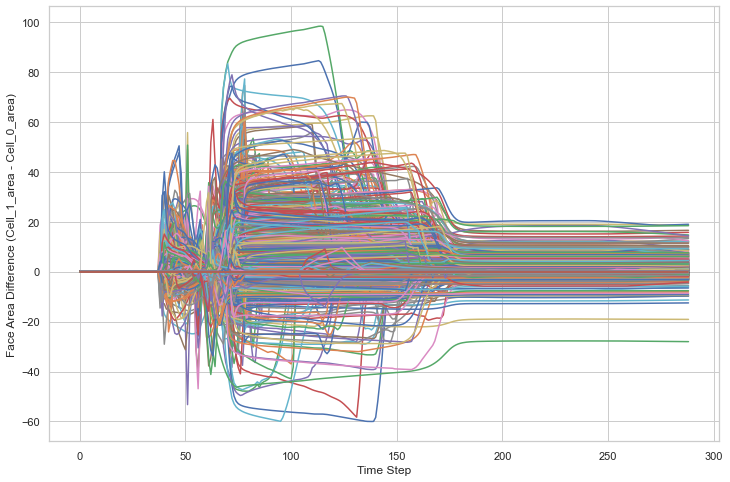

In [12]:
face_area_differences_df = face_areas_1_df - face_areas_0_df
ax = face_area_differences_df.plot(legend=None)
ax.set_xlabel('Time Step')
ax.set_ylabel('Face Area Difference (Cell_1_area - Cell_0_area)')

Text(0, 0.5, 'Face Area Percent Difference (Cell_1_area vs. Cell_0_area)')

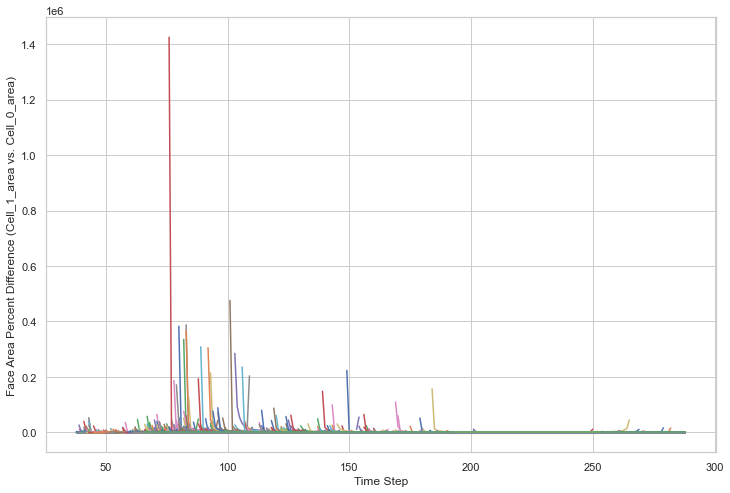

In [14]:
face_area_percent_differences_df = (face_areas_1_df - face_areas_0_df) / face_areas_0_df * 100
ax = face_area_percent_differences_df.plot(legend=None)
ax.set_xlabel('Time Step')
ax.set_ylabel('Face Area Percent Difference (Cell_1_area vs. Cell_0_area)')